In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

In [12]:
data = pd.read_csv("distances_Tpeak_temporal_ind_24102023_wide.csv")
data = data[(data["FlashType"] == 1) | (data["FlashType"] == 2)]


In [13]:
data

,participant_id,FlashType,NrBeeps,correct,rt,correct_abs,correct_rel,rt_abs,rt_rel,rt_Cod,...,bl_rt,CFF,sex,age,"Dist to A1, LH","Dist to A1, RH","Dist to V1, LH","Dist to V1, RH",dist_ratio_L,dist_ratio_R
0,13000,1,1,0.655172,0.780952,-0.166256,-0.202153,0.063081,0.074738,0.134535,...,0.844033,0.378,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
1,13000,1,2,0.148148,0.721360,-0.673280,-0.818649,0.122673,0.145341,0.240986,...,0.844033,0.378,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
2,13000,2,1,0.766667,1.063185,0.000000,0.000000,-0.255987,-0.317130,-0.357617,...,0.807198,0.378,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
3,13000,2,2,0.035714,0.673689,-0.730952,-0.952174,0.133509,0.165399,0.384151,...,0.807198,0.378,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
8,13159,1,1,0.900000,0.601145,-0.031034,-0.033298,0.080428,0.118003,0.527573,...,0.681572,0.798,0,20.9,50.384648,42.015179,75.118177,75.433732,0.670738,0.556981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,98735,2,2,0.000000,0.712788,-0.733333,-0.998638,0.435913,0.379484,1.123012,...,1.148702,0.294,0,21.0,67.239895,60.497360,85.877711,84.729887,0.782973,0.714003
2056,98754,1,1,1.000000,0.587829,0.000000,0.000000,0.008364,0.014030,0.073925,...,0.596193,0.378,0,25.3,62.952716,43.808906,81.537997,82.783578,0.772066,0.529198
2057,98754,1,2,0.035714,0.604471,-0.964286,-0.963322,-0.008278,-0.013884,-0.064203,...,0.596193,0.378,0,25.3,62.952716,43.808906,81.537997,82.783578,0.772066,0.529198
2058,98754,2,1,0.933333,0.620031,0.036782,0.352151,0.009158,0.014555,0.080380,...,0.629189,0.378,0,25.3,62.952716,43.808906,81.537997,82.783578,0.772066,0.529198


<Axes: xlabel='correct_rel', ylabel='Count'>

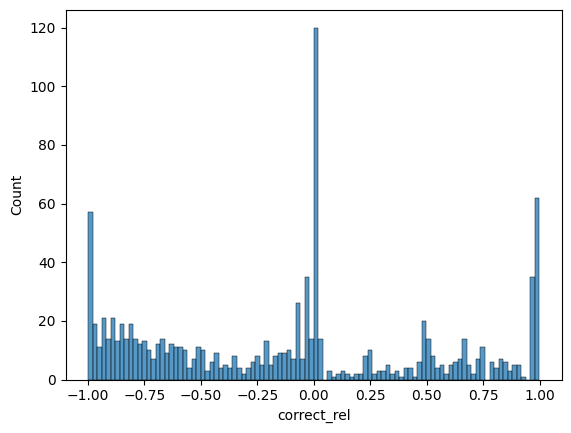

In [16]:
sns.histplot(data["correct_rel"], bins = 100)

In [7]:
correct_rel = data["correct_rel"]
rt_Cod = data["rt_Cod"]

In [8]:
data = data.drop(["participant_id","correct", "rt","correct_abs", "rt_abs", "correct_rel", "rt_Cod","rt_rel", "bl_correct","bl_rt", "CFF"], axis=1, index=None) # "Dist to V1, RH", "Dist to A1, RH", "Dist to A1, LH", "dist_ratio_R", "dist_ratio_L"

## Pipeline

In [6]:
num_features = data.columns[3:].to_list()
# ord_features = [data_flash1.columns[0]]
cat_features = data.columns[:3].to_list()

In [7]:
whiten = Pipeline(
    steps = [("whiten", StandardScaler())]
)

cat_encoder = Pipeline(
    steps = [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

ord_encoder = Pipeline(
    steps = [("cat_encoder", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("whiten", whiten, num_features),
        # ("ord_encoder", ord_encoder, cat_features),
        ("cat_encoder", cat_encoder, cat_features)
    ]
)

In [8]:
from sklearn import svm
svr = svm.SVR(kernel = "linear", epsilon = 0.2)
svr_pipe = Pipeline([('preprocessor', preprocessor),
                ('svr',svr)])

In [10]:
correct_rel

0      -0.202153
1      -0.818649
2       0.000000
3      -0.952174
8      -0.033298
          ...   
2051   -0.998638
2056    0.000000
2057   -0.963322
2058    0.352151
2059   -0.998886
Name: correct_rel, Length: 1032, dtype: float64

In [9]:
data

,FlashType,NrBeeps,sex,age,"Dist to A1, LH","Dist to A1, RH","Dist to V1, LH","Dist to V1, RH",dist_ratio_L,dist_ratio_R
0,1,1,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
1,1,2,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
2,2,1,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
3,2,2,1,20.7,61.522872,71.641146,77.166546,80.322080,0.797274,0.891923
8,1,1,0,20.9,50.384648,42.015179,75.118177,75.433732,0.670738,0.556981
...,...,...,...,...,...,...,...,...,...,...
2051,2,2,0,21.0,67.239895,60.497360,85.877711,84.729887,0.782973,0.714003
2056,1,1,0,25.3,62.952716,43.808906,81.537997,82.783578,0.772066,0.529198
2057,1,2,0,25.3,62.952716,43.808906,81.537997,82.783578,0.772066,0.529198
2058,2,1,0,25.3,62.952716,43.808906,81.537997,82.783578,0.772066,0.529198


## 5-fold Cross-validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, correct_rel, test_size=0.25, random_state=42)

In [10]:
cat_feature_names = ["FlashType_1", "FlashType_2", "NrBeeps_1", "NrBeeps_2", "Sex_0", "Sex_1"]
feature_names = cat_feature_names + list(num_features)

In [11]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = cross_validate(svr_pipe, X_train, y_train, cv=cv, scoring=['r2', 'neg_mean_squared_error'], return_estimator =True, n_jobs = -1)

In [12]:
print("Mean R2 across folds: ", np.mean(cv_results['test_r2']))
print("Mean MSE across folds: ", np.mean(cv_results['test_neg_mean_squared_error']))

Mean R2 across folds:  0.643383599815618
Mean MSE across folds:  -0.1444424004291459


In [13]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ],
    columns = feature_names
)

Text(0.5, 1.0, 'Coefficient importance and its variability')

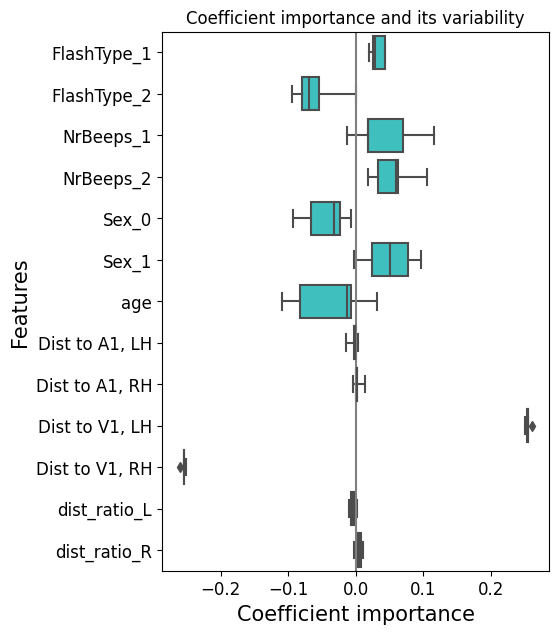

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## Check predictions

In [15]:
trained_svr = svr.fit(X_train, y_train)

/home/victoria/.conda/envs/neuro/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


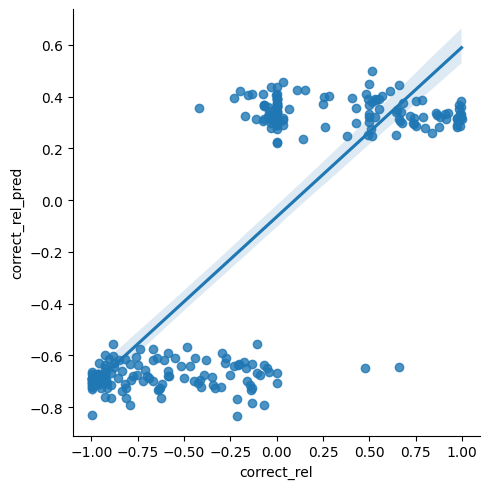

In [16]:
y_pred = trained_svr.predict(X_test)
test_pred_df = pd.DataFrame({"correct_rel": y_test, "correct_rel_pred": y_pred})
sns.lmplot(test_pred_df, x = "correct_rel", y = "correct_rel_pred")

## Model diagnostics

In [17]:
y_train_pred = trained_svr.predict(X_train)

In [18]:
from sklearn.metrics import r2_score

print("R squared: {}".format(r2_score(y_true=y_train,y_pred=y_train_pred)))

R squared: 0.6640580752124541


In [19]:
residuals = y_train.values-y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 0.05283602570318633


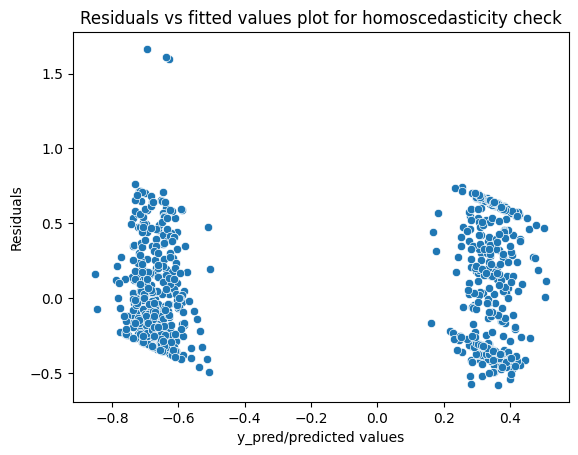

In [20]:
residuals_train = pd.DataFrame({"y_train_pred": y_train_pred, "residuals": residuals})

p = sns.scatterplot(residuals_train, x = "y_train_pred", y = "residuals")
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [21]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0388048724004102), ('p-value', 0.3559351667869693)]

## Permutation feature importance

In [22]:
from sklearn.inspection import permutation_importance

perm_acc = permutation_importance(trained_svr, X_test, y_test,n_repeats=1000, random_state=42, n_jobs = -1)
perm_sorted_idx = perm_acc.importances_mean
perm_std = perm_acc.importances_std
null_dist_coefs = perm_acc.importances

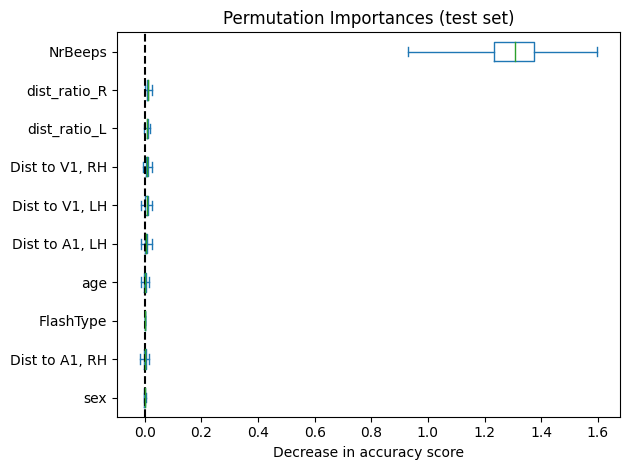

In [23]:
sorted_importances_idx = perm_acc.importances_mean.argsort()
importances = pd.DataFrame(
    perm_acc.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()